<a href="https://colab.research.google.com/github/aloiswirth/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/aloiswirth/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
print(sys.version_info)
print(sys.version)
print(tf.__version__)
print(sklearn.__version__)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
2.2.0
0.22.2.post1


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [0]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [5]:
y_pred

array([1])

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
print(" a = ", a, " b= ", b)

 a =  -0.6363636363636362  b=  [1.81818182]


Saving figure perceptron_iris_plot


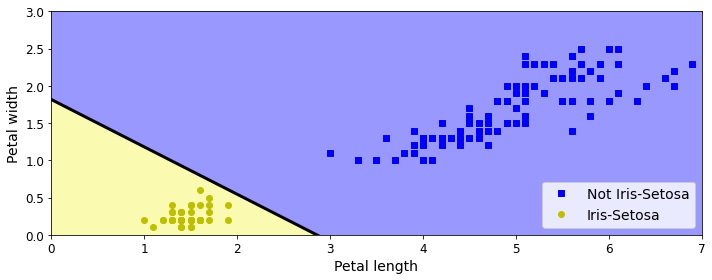

In [7]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 7, 0, 3]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


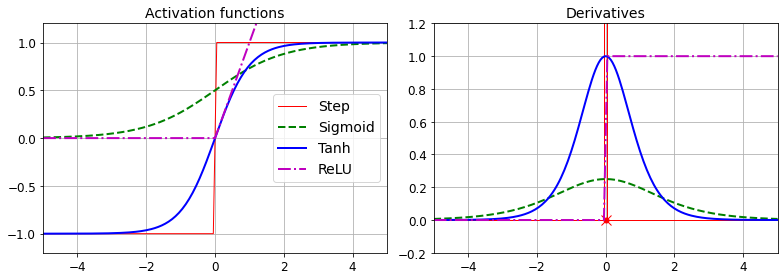

In [9]:
z = np.linspace(-5, 5, 201)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [10]:
print(z)

[-5.   -4.95 -4.9  -4.85 -4.8  -4.75 -4.7  -4.65 -4.6  -4.55 -4.5  -4.45
 -4.4  -4.35 -4.3  -4.25 -4.2  -4.15 -4.1  -4.05 -4.   -3.95 -3.9  -3.85
 -3.8  -3.75 -3.7  -3.65 -3.6  -3.55 -3.5  -3.45 -3.4  -3.35 -3.3  -3.25
 -3.2  -3.15 -3.1  -3.05 -3.   -2.95 -2.9  -2.85 -2.8  -2.75 -2.7  -2.65
 -2.6  -2.55 -2.5  -2.45 -2.4  -2.35 -2.3  -2.25 -2.2  -2.15 -2.1  -2.05
 -2.   -1.95 -1.9  -1.85 -1.8  -1.75 -1.7  -1.65 -1.6  -1.55 -1.5  -1.45
 -1.4  -1.35 -1.3  -1.25 -1.2  -1.15 -1.1  -1.05 -1.   -0.95 -0.9  -0.85
 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45 -0.4  -0.35 -0.3  -0.25
 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35
  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95
  1.    1.05  1.1   1.15  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55
  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15
  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75
  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3

In [0]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

In [12]:
print(heaviside(z))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
x1s = np.linspace(-0.2, 1.2, 141)
x2s = np.linspace(-0.2, 1.2, 141)
print(x1s)

[-0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39
  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51
  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63
  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74  0.75
  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83  0.84  0.85  0.86  0.87
  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99
  1.    1.01  1.02  1.03  1.04  1.05  1.06  1.07  1.08  1.09  1.1   1.11
  1.12  1.13  1.14  1.15  1.16  1.17  1.18  1.19  1.2 ]


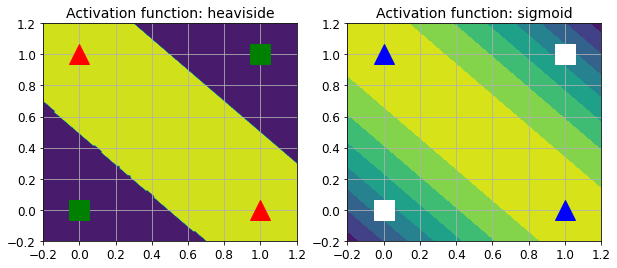

In [14]:

x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
# plt.plot([0.5, 0.6], [0.3, 0.7], "gs", markersize=5)
plt.plot([0, 1], [1, 0], "r^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "ws", markersize=20)
plt.plot([0, 1], [1, 0], "b^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [0]:
import tensorflow as tf
from tensorflow import keras

In [16]:
tf.__version__

'2.2.0'

In [17]:
keras.__version__

'2.3.0-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [19]:
X_train_full.shape

(60000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

In [21]:
y_train_full.shape

(60000,)

In [22]:
y_test.shape

(10000,)

Each pixel intensity is represented as a byte (0 to 255):

In [23]:
X_train_full.dtype

dtype('uint8')

In [24]:
y_test.dtype

dtype('uint8')

In [25]:
print(y_train_full.dtype)
print(y_train_full[0])

uint8
9


Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [0]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [27]:
print(X_train_full[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [28]:
print(X_valid[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00392157 0.    

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

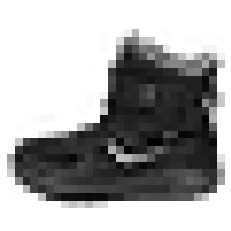

In [29]:
plt.imshow(X_valid[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [30]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [0]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [32]:
class_names[y_train[0]]

'Coat'

In [33]:
class_names[y_valid[0]]

'Ankle boot'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [34]:
X_valid.shape

(5000, 28, 28)

In [35]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


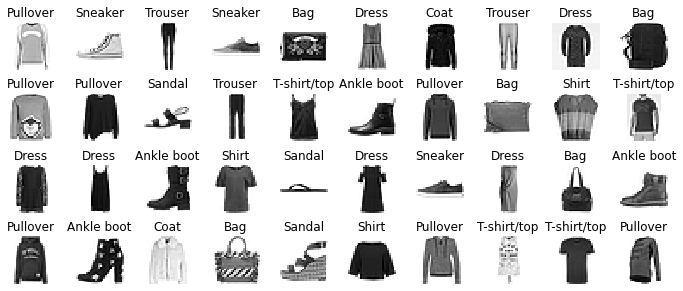

In [36]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index+100], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index+100]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.layers

In [0]:
keras.backend.clear_session()

In [40]:
model.layers

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.layers

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


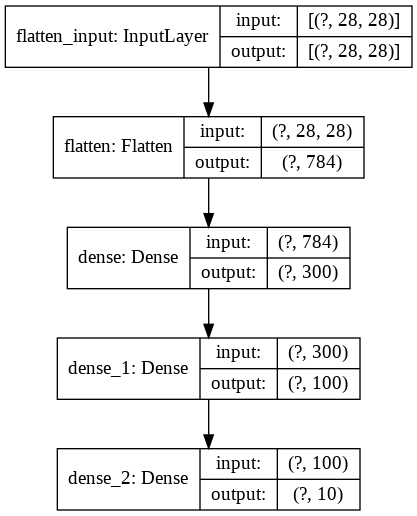

In [45]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [46]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [47]:
model.get_layer(hidden1.name) is hidden1

True

In [48]:
hidden2 = model.layers[2]
hidden2.name

'dense_1'

In [49]:
hidden2.output_shape

(None, 100)

In [0]:
weights, biases = hidden1.get_weights()

In [51]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [52]:
weights.shape

(784, 300)

In [53]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [54]:
biases.shape

(300,)

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [56]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4842 - accuracy: 0.8318 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4391 - accuracy: 0.8458 - val_loss: 0.5304 - val_accuracy: 0.7996
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4123 - accuracy: 0.8566 - val_loss: 0.3916 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3939 - accuracy: 0.8622 - val_loss: 0.3745 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3752 - accuracy: 0.8675 - val_loss: 0.3718 - val_accuracy: 0.8724
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3631 - accuracy: 0.8716 - val_loss: 0.3616 - val_accuracy:

In [57]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [58]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
history2 = model.fit(X_train, y_train, epochs =30,  validation_split=0.1) 


Epoch 1/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2199 - accuracy: 0.9212 - val_loss: 0.2314 - val_accuracy: 0.9142
Epoch 2/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2162 - accuracy: 0.9225 - val_loss: 0.2363 - val_accuracy: 0.9125
Epoch 3/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2131 - accuracy: 0.9244 - val_loss: 0.2263 - val_accuracy: 0.9175
Epoch 4/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2092 - accuracy: 0.9247 - val_loss: 0.2228 - val_accuracy: 0.9198
Epoch 5/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2061 - accuracy: 0.9264 - val_loss: 0.2314 - val_accuracy: 0.9151
Epoch 6/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2034 - accuracy: 0.9266 - val_loss: 0.2368 - val_accuracy: 0.9129
Epoch 7/30
1547/1547 [==============================] - 5s 3ms/step - loss: 0.1987 - accuracy: 0.9291 - val_loss: 0.2277 - val_accuracy:

Saving figure keras_learning_curves_plot


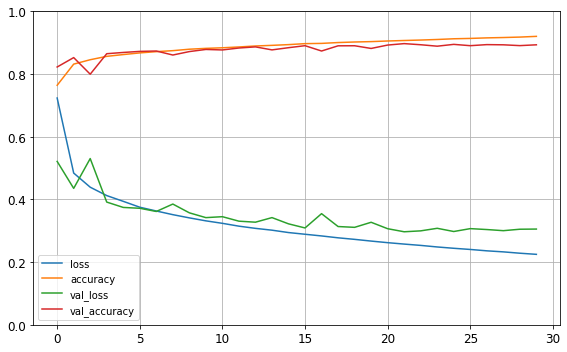

In [61]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [62]:
print(len(y_test))

10000


In [63]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3428 - accuracy: 0.8863


[0.3427733778953552, 0.8863000273704529]

In [65]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   ,
        0.998],
       [0.   , 0.   , 0.996, 0.   , 0.004, 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]], dtype=float32)

In [66]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1])

In [68]:
y_pred_new = np.argmax(model.predict(X_new), axis=-1)
print(y_pred_new)

[9 2 1]


In [69]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [70]:
np.array(class_names)[y_pred_new]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [71]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

In [72]:
np.array(class_names)[y_new]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Saving figure fashion_mnist_images_plot


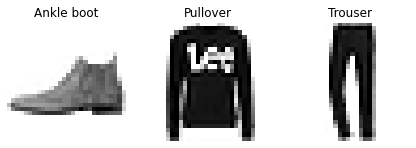

In [73]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [74]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [75]:
print(X_train_full.shape)
print(X_test.shape)

(15480, 8)
(5160, 8)


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

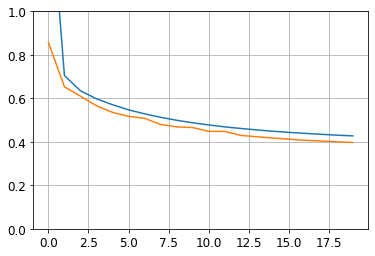

In [79]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [80]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [83]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [84]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4659 - val_loss: 0.4313

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [87]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

Adding an auxiliary output for regularization:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [0]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [92]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
  1/363 [..............................] - ETA: 0s - loss: 6.9006 - main_output_loss: 7.0091 - aux_output_loss: 5.9244

KeyboardInterrupt: ignored

In [0]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 918us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# The subclassing API

In [0]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [0]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

In [0]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8542 - val_loss: 1.3779
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7854 - val_loss: 0.6885
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.6817 - val_loss: 0.6645
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6283 - val_loss: 0.5944
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5868 - val_loss: 0.5505
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5510 - val_loss: 0.5211
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5225 - val_loss: 0.5055
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4993 - val_loss: 0.4648
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4803 - val_loss: 0.4442
Epoch 10/10
162/162 [==============================] - 0s 845us/step - loss: 0.4472


In [0]:
model.save("my_keras_model.h5")

In [0]:
model = keras.models.load_model("my_keras_model.h5")

In [0]:
model.predict(X_new)

array([[0.8035599],
       [1.5589916],
       [3.0034246]], dtype=float32)

In [0]:
model.save_weights("my_keras_weights.ckpt")

In [0]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 804us/step - loss: 0.4382


In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3976 - val_lo

In [0]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [0]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

326/363 [=========================>....] - ETA: 0s - loss: 0.3292
val/train: 1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3302 - val_loss: 0.3561


# TensorBoard

In [0]:
root_logdir = os.path.join(os.curdir, "alois_logs")

In [0]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./alois_logs/run_2020_05_19-18_21_14'

In [0]:
print(root_logdir)

./alois_logs


In [0]:
import subprocess
my_dir = subprocess.run(["ls", "-l"])
print(my_dir)
# for x in my_dir:
#   print(x)

CompletedProcess(args=['ls', '-l'], returncode=0)


In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [0]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4474 - val_loss: 0.4379

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./alois_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [0]:
%load_ext tensorboard
%tensorboard --logdir=./alois_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2020-05-19 18:37:52.936010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
E0519 18:37:54.599671 140539631740800 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [0]:
run_logdir2 = get_run_logdir()
run_logdir2

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [0]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [0]:
help(keras.callbacks.TensorBoard.__init__)

# Hyperparameter Tuning

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [0]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [0]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [0]:
mse_test = keras_reg.score(X_test, y_test)

In [0]:
y_pred = keras_reg.predict(X_new)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [0]:
rnd_search_cv.best_params_

In [0]:
rnd_search_cv.best_score_

In [0]:
rnd_search_cv.best_estimator_

In [0]:
rnd_search_cv.score(X_test, y_test)

In [0]:
model = rnd_search_cv.best_estimator_.model
model

In [0]:
model.evaluate(X_test, y_test)

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

TODO